In [42]:
SHOW_ith_ATTENTIONT = 0
fen = "1qr3k1/5ppp/8/8/8/7Q/5PPP/2R3K1 w - - 0 1"
check_at = 'c8'

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeedForward(nn.Module):
    def __init__(self, model_dim, ff_dim, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(model_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, model_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class MultiHeadGATEAULayer(nn.Module):

    def __init__(self, node_in_features, edge_in_features, node_out_features, num_heads=8):
        super(MultiHeadGATEAULayer, self).__init__()
        assert node_out_features % num_heads == 0, "node_out_features must be divisible by num_heads"

        self.node_in_features = node_in_features
        self.edge_in_features = edge_in_features
        self.node_out_features = node_out_features
        self.num_heads = num_heads
        self.head_dim = node_out_features // num_heads
        
        self.Wv = nn.Parameter(torch.randn(node_in_features, edge_in_features))
        self.Wu = nn.Parameter(torch.randn(node_in_features, edge_in_features))
        self.We = nn.Parameter(torch.randn(edge_in_features, edge_in_features))
        self.W_global_edge = nn.Parameter(torch.randn(node_in_features, edge_in_features))
        
        self.Wh = nn.Parameter(torch.randn(node_in_features, node_out_features))
        self.Wg = nn.Parameter(torch.randn(edge_in_features, node_out_features))
        self.W0 = nn.Parameter(torch.randn(node_in_features, node_out_features))
        self.W_global_node = nn.Parameter(torch.randn(node_in_features, node_out_features))

        self.a = nn.Parameter(torch.randn(num_heads, self.head_dim))
        
        self.W_out = nn.Linear(node_out_features, node_out_features)

        self.a_proj = nn.Linear(self.edge_in_features, self.num_heads)

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.Wv)
        nn.init.xavier_uniform_(self.Wu)
        nn.init.xavier_uniform_(self.We)
        nn.init.xavier_uniform_(self.W_global_edge)
        nn.init.xavier_uniform_(self.Wh)
        nn.init.xavier_uniform_(self.Wg)
        nn.init.xavier_uniform_(self.W0)
        nn.init.xavier_uniform_(self.W_global_node)
        nn.init.xavier_uniform_(self.W_out.weight)
        nn.init.zeros_(self.W_out.bias)
        nn.init.xavier_uniform_(self.a)

    def forward(self, node_feature_matrix, edge_feature_matrix, edge_index, edge_map, global_node_features):
        num_nodes = node_feature_matrix.shape[0]
        num_edges = edge_index.shape[1]
        target_node_idx, source_node_idx = edge_index[0], edge_index[1]

        h_nodes_v = node_feature_matrix @ self.Wv
        h_nodes_u = node_feature_matrix @ self.Wu
        h_edges_e = edge_feature_matrix @ self.We
        h_global = global_node_features @ self.W_global_edge

        h_nodes_h = (node_feature_matrix @ self.Wh).view(-1, self.num_heads, self.head_dim)
        h_edges_g = (edge_feature_matrix @ self.Wg).view(-1, self.num_heads, self.head_dim)
        h_nodes_0 = (node_feature_matrix @ self.W0).view(-1, self.num_heads, self.head_dim)

        target_node_feats_for_attention = h_nodes_u[target_node_idx]
        source_node_feats_for_attention = h_nodes_v[source_node_idx]
        edge_feats_for_attention = h_edges_e[edge_map]
        global_feats_for_attention = h_global[target_node_idx]
        
        new_edge_feature_for_attention = target_node_feats_for_attention + source_node_feats_for_attention + edge_feats_for_attention + global_feats_for_attention
        new_edge_feature_for_attention = new_edge_feature_for_attention.unsqueeze(1).repeat(1, self.num_heads, 1)
        
        if not hasattr(self, 'a_proj'):
            nn.init.xavier_uniform_(self.a_proj.weight)

        attention_logits = self.a_proj(new_edge_feature_for_attention[:, 0, :]).view(num_edges, self.num_heads) 
        attention_scores = self.leaky_relu(attention_logits) 
        max_scores = torch.full((num_nodes, self.num_heads), -1e9, device=attention_scores.device, dtype=attention_scores.dtype)
        max_scores.scatter_reduce_(0, target_node_idx.unsqueeze(-1).expand_as(attention_scores), attention_scores, reduce="amax", include_self=False)
        
        scores_max_per_edge = max_scores[target_node_idx]
        attention_scores_exp = torch.exp(attention_scores - scores_max_per_edge)

        sum_exp_scores = torch.zeros_like(max_scores)
        sum_exp_scores.index_add_(0, target_node_idx, attention_scores_exp)
        
        sum_exp_per_edge = sum_exp_scores[target_node_idx]
        alpha = attention_scores_exp / (sum_exp_per_edge + 1e-10)

        node_attention_scores = torch.zeros((num_nodes, self.num_heads), device=alpha.device)
        node_attention_scores.index_add_(0, target_node_idx, alpha)
        
        source_node_values = h_nodes_h[source_node_idx]
        edge_values = h_edges_g[edge_map]
        values = source_node_values + edge_values
        
        weighted_values = values * alpha.unsqueeze(-1)

        aggregated_messages = torch.zeros_like(h_nodes_0)
        aggregated_messages.index_add_(0, target_node_idx, weighted_values)
        
        projected_global_for_update = (global_node_features @ self.W_global_node).view(-1, self.num_heads, self.head_dim)

        new_h = h_nodes_0 + aggregated_messages + projected_global_for_update
        
        concatenated_h = new_h.view(-1, self.node_out_features)
        new_final = self.W_out(concatenated_h)
        new_edge_feature = target_node_feats_for_attention + source_node_feats_for_attention + edge_feats_for_attention + global_feats_for_attention
        
        return new_final, new_edge_feature, alpha

class GATEAUTransformerBlock(nn.Module):
    def __init__(self, node_features, edge_features, num_heads, ff_dim, dropout=0.1):
        super(GATEAUTransformerBlock, self).__init__()
        
        self.attention = MultiHeadGATEAULayer(
            node_in_features=node_features,
            edge_in_features=edge_features,
            node_out_features=node_features, 
            num_heads=num_heads
        )
        self.norm1 = nn.LayerNorm(node_features)
        self.dropout1 = nn.Dropout(dropout)

        self.ffn = FeedForward(
            model_dim=node_features, 
            ff_dim=ff_dim, 
            dropout=dropout
        )
        self.norm2 = nn.LayerNorm(node_features)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, node_feature_matrix, edge_feature_matrix, edge_index, edge_map, global_node_features):
        residual = node_feature_matrix
        x_norm = self.norm1(node_feature_matrix)
        
        attn_output, new_edge_features, attention_weights = self.attention(
            x_norm, edge_feature_matrix, edge_index, edge_map, global_node_features
        )
        
        x = residual + self.dropout1(attn_output)

        residual = x
        x_norm = self.norm2(x)
        ffn_output = self.ffn(x_norm)
        output_node_features = residual + self.dropout2(ffn_output)

        return output_node_features, new_edge_features, attention_weights

class GlobalNodeUpdater(nn.Module):
    def __init__(self, hidden_features):
        super(GlobalNodeUpdater, self).__init__()
        self.gate_linear = nn.Linear(hidden_features * 2, hidden_features)
        self.candidate_linear = nn.Linear(hidden_features * 2, hidden_features)
        self.hidden_features = hidden_features

    def forward(self, global_node, node_features, batch_size):
        num_nodes_per_graph = node_features.shape[0] // batch_size
        
        # Reshape to (batch_size, num_nodes, features) and aggregate
        node_features_reshaped = node_features.view(batch_size, num_nodes_per_graph, self.hidden_features)
        mean_node_features = node_features_reshaped.mean(dim=1) # Shape: (batch_size, hidden_features)

        combined = torch.cat([global_node, mean_node_features], dim=-1)

        update_gate = torch.sigmoid(self.gate_linear(combined))
        candidate_state = torch.tanh(self.candidate_linear(combined))

        new_global_node = (1 - update_gate) * global_node + update_gate * candidate_state
        return new_global_node

class ChessGNN(nn.Module):
    def __init__(self, node_in_features, edge_in_features, global_node_in_features, gnn_hidden_features, num_possible_moves, 
                 num_res_layers=10, num_heads=8, ff_dim=512, dropout=0.1):
        super(ChessGNN, self).__init__()
        
        self.input_proj_node = nn.Linear(node_in_features, gnn_hidden_features)
        self.input_proj_edge = nn.Linear(edge_in_features, gnn_hidden_features)
        self.input_proj_global = nn.Linear(global_node_in_features, gnn_hidden_features)

        self.gnn_layers = nn.ModuleList()
        self.global_updaters = nn.ModuleList()
        
        for _ in range(num_res_layers):
            self.gnn_layers.append(GATEAUTransformerBlock(
                node_features=gnn_hidden_features,
                edge_features=gnn_hidden_features,
                num_heads=num_heads,
                ff_dim=ff_dim,
                dropout=dropout
            ))
            self.global_updaters.append(GlobalNodeUpdater(gnn_hidden_features))

        self.final_norm = nn.LayerNorm(gnn_hidden_features)

        self.policy_head = nn.Sequential(
            nn.Linear(64 * gnn_hidden_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_possible_moves)
        )

        self.value_head = nn.Sequential(
            nn.Linear(64 * gnn_hidden_features, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Tanh() 
        )

    def forward(self, node_feature_matrix, edge_feature_matrix, global_node_vector, edge_index, edge_map, batch_size):
        x = self.input_proj_node(node_feature_matrix)
        e = self.input_proj_edge(edge_feature_matrix)
        
        current_global_node = self.input_proj_global(global_node_vector)
        
        num_nodes_per_graph = x.shape[0] // batch_size

        first_layer_attention = None
        
        for i, layer in enumerate(self.gnn_layers):
            expanded_global_node = current_global_node.unsqueeze(1).repeat(1, num_nodes_per_graph, 1).view(batch_size * num_nodes_per_graph, -1)
            
            x, e, attention_weights = layer(x, e, edge_index, edge_map, expanded_global_node)

            if i == SHOW_ith_ATTENTIONT:
                first_layer_attention = attention_weights
            
            updater = self.global_updaters[i]
            current_global_node = updater(current_global_node, x, batch_size)

        processed_node_features = self.final_norm(x)
        graph_representation = processed_node_features.view(batch_size, -1)
        policy_logits = self.policy_head(graph_representation)
        value = self.value_head(graph_representation)

        return policy_logits, value, first_layer_attention
    

In [44]:
import os
import torch
from our_graph2_encode import encode_node_features, encode_edge_features, encode_global_node_features, static_edge_index, static_edge_map, base_graph_edges, index_to_move, get_incoming_move_indices

import chess
import numpy as np
attention_map = None
    
def start_model(checkpoint_file_name="checkpoint_epoch_41.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    NODE_IN_FEATURES = 12
    EDGE_IN_FEATURES = 11
    GNN_NODE_OUT_FEATURES = 56
    GLOBAL_NODE_IN_FEATURES = 9
    NUM_POSSIBLE_MOVES = 1792

    model = ChessGNN(
        node_in_features=NODE_IN_FEATURES,
        edge_in_features=EDGE_IN_FEATURES,
        global_node_in_features=GLOBAL_NODE_IN_FEATURES,
        gnn_hidden_features=GNN_NODE_OUT_FEATURES,
        num_possible_moves=NUM_POSSIBLE_MOVES,
    ).to(device)



    checkpoint = torch.load(checkpoint_file_name, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model


def model_predict(model, board):
    global attention_map
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    node_features = torch.tensor(encode_node_features(board)).to(device) # [B * 64, 12]
    edge_features = torch.tensor(encode_edge_features(board, base_graph_edges)).to(device) # [B * 1792, 11]
    global_features = torch.tensor(encode_global_node_features(board).reshape(1,9)).to(device)# [B * 1, 9]
    edge_index = static_edge_index.to(device)             # [B * 1792, 11]
    edge_map = static_edge_map.to(device)                 # [1792]

    policy_logits, value_pred, attention_map = model(
        node_feature_matrix=node_features,
        edge_feature_matrix=edge_features,
        global_node_vector=global_features,
        edge_index=edge_index,
        edge_map=edge_map,
        batch_size=1
    )

    policy_logits = policy_logits.to("cpu")
    policy_logits = policy_logits.detach().numpy()

    value_pred = value_pred.to("cpu")
    value_pred = value_pred.detach().numpy()

    return policy_logits, value_pred


board = chess.Board(fen)
model = start_model()

policy_logits, value_pred = model_predict(model, board)

index = np.argmax(policy_logits)




the_map = np.zeros((8,8,8))

attention_map.shape
iss,fss = get_incoming_move_indices(check_at)
for i,f in zip(iss,fss):
    the_map[7 - f//8,f%8] = attention_map[i].cpu().detach().numpy()
        


Using device: cpu


C:\Users\Adrian\AppData\Local\Temp\ipykernel_8848\3482328502.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file_name, map_location=

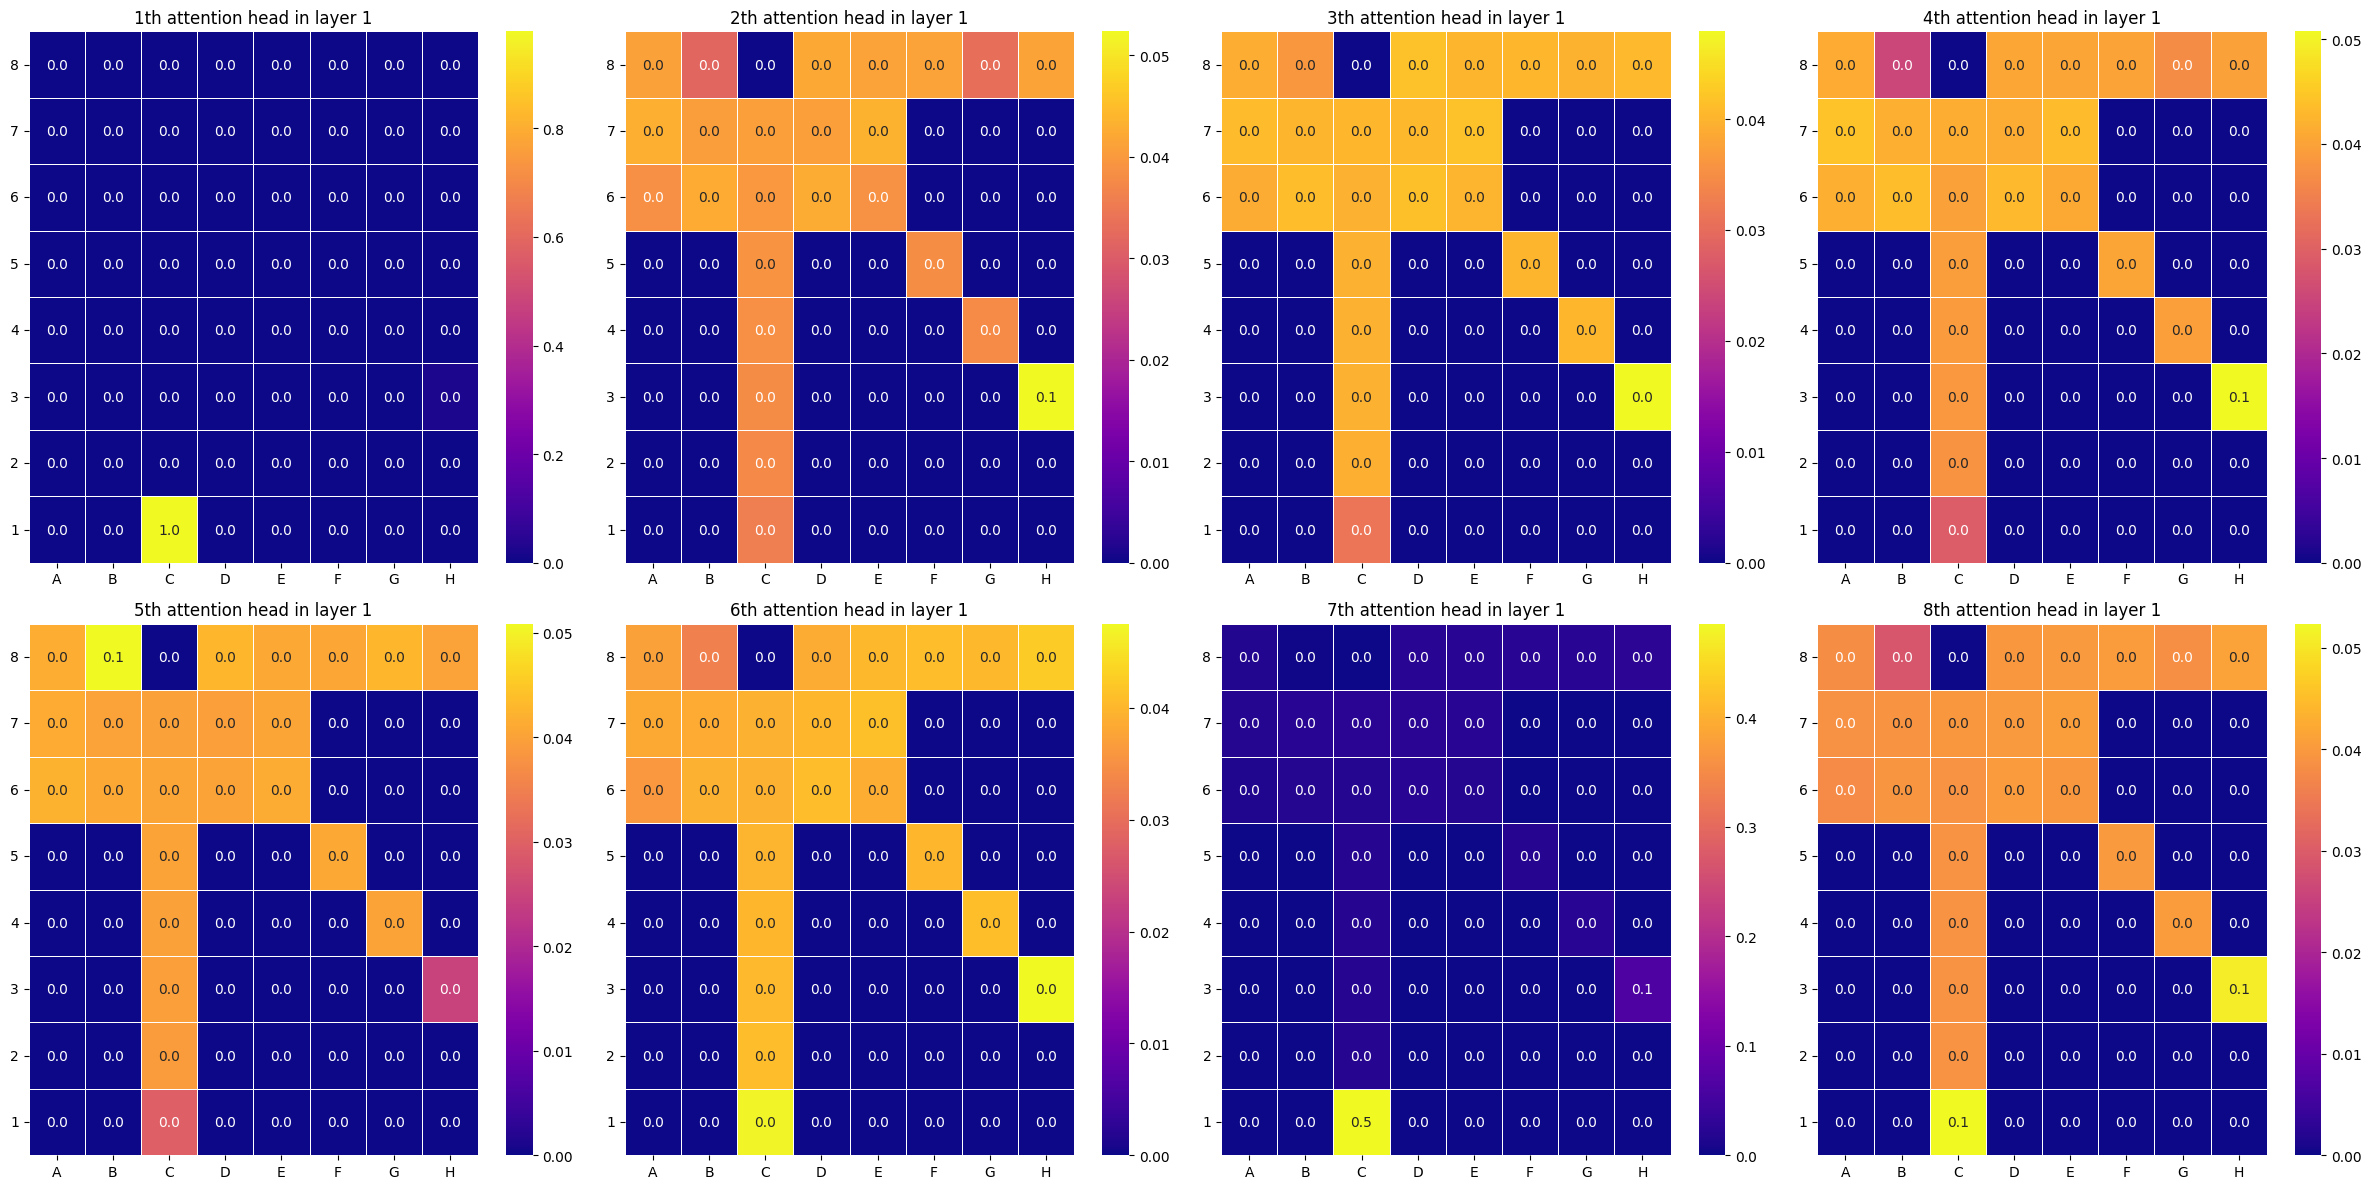

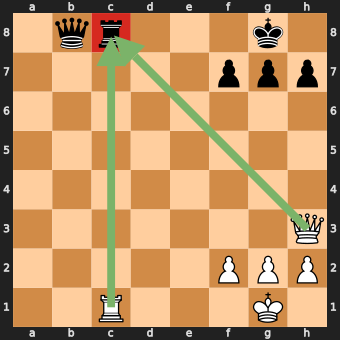

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

x_axis_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
y_axis_labels = ['8', '7', '6', '5', '4', '3', '2', '1']


fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.flatten()

for i, ax in enumerate(axes):

    data = the_map[:,:,i]
    min_val = 0  
    max_val = data.max() 

    sns.heatmap(
        data, 
        ax=ax, 
        annot=True,               
        fmt='.1f',               
        cmap='plasma',           
        linewidths=.5,
        xticklabels=x_axis_labels, 
        yticklabels=y_axis_labels
    )
    
    title = f'{i+1}th attention head in layer {SHOW_ith_ATTENTIONT+1}'
    ax.set_title(title, fontsize=12)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout()

plt.show()

svg = chess.svg.board(
    board,
    fill={chess.parse_square(check_at): "#cc0000cc"},
    arrows=[
        chess.svg.Arrow(chess.Move.from_uci("c1c8").from_square, chess.Move.from_uci("c1c8").to_square, color="#7bb369dd"),
        chess.svg.Arrow(chess.Move.from_uci("h3c8").from_square, chess.Move.from_uci("h3c8").to_square, color="#7bb369dd")
    ],
    size=340,
) 
svg